# Temporal-Difference Methods

In this notebook, I wrote my own implementations of the following Temporal-Difference (TD) methods: SARSA, SARSAMAX (Q-Learning), Expected SARSA

I used some of the starter code provided by Udacity and modified it or added my own code where necessary. I also include additional remarks and comments for easing the understanding of the code.

---

## Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

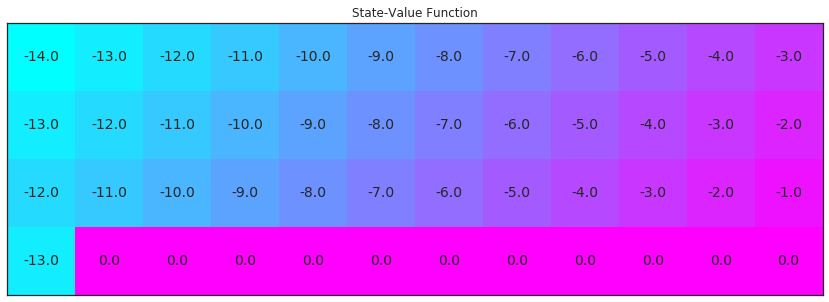

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

---
## Part 1: TD Control: Sarsa

In this section, I wrote my own implementation of the SARSA control algorithm.

The algorithm has five arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

#### Pseudocode for SARSA algorithm
<img src='images/TD_SARSA_algorithm.png' width='800'>

In [5]:
def pick_action(env, Qs, epsilon):
    ''' select action from e-greedy policy'''
    prob = epsilon_greedy_probs(Qs, epsilon, env.nA)
    action = np.random.choice(np.arange(env.nA), p = prob)
        
    return action

def epsilon_greedy_probs(Qs, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA      # prob for non-greedy action
    best_a = np.argmax(Qs)                     # identification of best action in Q(s,a)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)  # prob for greedy action (max Q(s,a))
    
    return policy_s


def update_Q_sarsa(Qsa, Qsa_next, reward, alpha, gamma):
    """ updates the action-value function estimate using SARSA method """

    return (Qsa + alpha*(reward + gamma * Qsa_next - Qsa))

In [15]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        # epsilon setting
        # Algorithm performance higly dependent of epsilon decay policy
        epsilon_start = 1.0
        epsilon = epsilon_start / i_episode          # option 1 prefered here
        #epsilon = max(epsilon_start * 0.95, 0.05)   # option 2  
        #epsilon = epsilon_start                     # option 3
        
        # Initizialising time step
        t = 0
        # Start an episode
        state = env.reset()
        # Pick first action
        action = pick_action(env, Q[state], epsilon)
        
        while True:
            # Take action and observe result
            next_state, reward, done, info = env.step(action)
            
            # Pick next action
            next_action = pick_action(env, Q[next_state], epsilon)
            
            # Q-table update
            Q[state][action] = update_Q_sarsa(Q[state][action], Q[next_state][next_action], reward, alpha, gamma)
            
            # Pass new values for next interaction
            t += 1
            state, action = next_state, next_action
            
            # Q-table update if action leads to terminal state
            if done:
                Q[state][action] = update_Q_sarsa(Q[state][action], 0.0, reward, alpha, gamma)               
                break
                
    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  3  1  2  0  1  1  3  2  1  1  2]
 [ 0  1  1  1  1  1  1  1  2  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


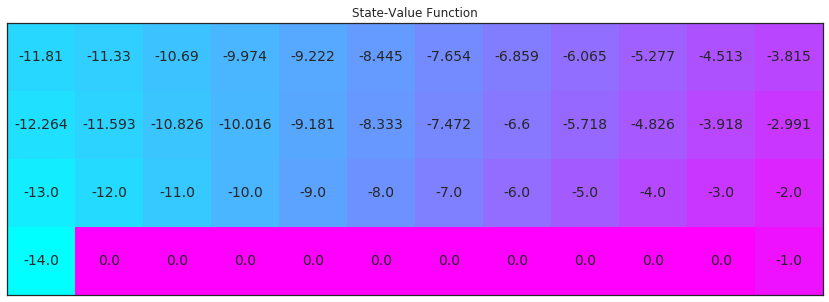

In [16]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

---
## Part 2: TD Control: SARSAMAX (Q-learning)

In this section, I wrote my own implementation of the SARSAMAX (Q-learning) control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

#### Pseudocode for SARSAMAX algorithm
<img src='images/TD_SARSAMAX_algorithm.png' width='800'>

In [17]:
def update_Q_sarsamax(Qsa, Qs_next, reward, alpha, gamma):
    """ updates the action-value function estimate using SARSAMAX method """
    best_a = np.argmax(Qs_next)   # index of best action (= max Qs)

    return (Qsa + alpha*(reward + gamma * Qs_next[best_a] - Qsa))

In [18]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # epsilon setting
        # Algorithm performance higly dependent of epsilon decay policy
        epsilon_start = 1.0
        epsilon = epsilon_start / i_episode          # option 1 prefered here
        #epsilon = max(epsilon_start * 0.95, 0.05)   # option 2
        #epsilon = epsilon_start                     # option 3
        
        # Initizialising time step
        t = 0
        # Start an episode
        state = env.reset()
                
        while True:
            # Pick action
            action = pick_action(env, Q[state], epsilon)
            
            # Take action and observe result
            next_state, reward, done, info = env.step(action)
            
            # Q-table update
            Q[state][action] = update_Q_sarsamax(Q[state][action], Q[next_state], reward, alpha, gamma)
            
            # Pass new values for next interaction
            t += 1
            state = next_state
            
            # Q-table update if action leads to terminal state
            if done:
                Q[state][action] = update_Q_sarsamax(Q[state][action], [0.0], reward, alpha, gamma)
                break
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  1  1  1  0  1  1  2  2  2  0]
 [ 1  1  1  0  1  1  1  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


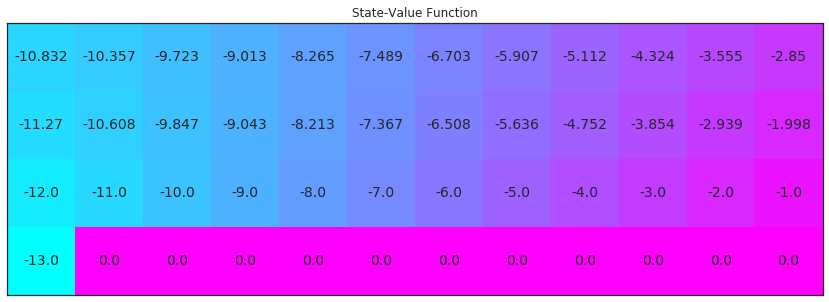

In [19]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

---
## Part 3: TD Control: Expected Sarsa

In this section, I wr0te my own implementation of the Expected Sarsa control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

#### Pseudocode for EXPECTED SARSA algorithm
<img src='images/TD_EXPECTED_SARSA_algorithm.png' width='800'>

In [20]:
def update_Q_expected_sarsa(Qsa, Qs_next, epsilon, nA, reward, alpha, gamma):
    """ updates the action-value function estimate using Expected SARSA method """
    prob = epsilon_greedy_probs(Qs_next, epsilon, nA)
    sum_Qs_next = sum(prob * Qs_next)

    return (Qsa + alpha*(reward + gamma * sum_Qs_next - Qsa))

In [21]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # epsilon setting with decay
        # Algorithm performance higly dependent of epsilon decay policy
        epsilon_start = 0.005 
        #epsilon = epsilon_start / i_episode         # option 1
        #epsilon = max(epsilon_start * 0.95, 0.05)   # option 2
        epsilon = epsilon_start                      # option 3 prefered here
        
        # Initizialising time step
        t = 0
        # Start an episode
        state = env.reset()
                
        while True:
            # Pick action
            action = pick_action(env, Q[state], epsilon)
            
            # Take action and observe result
            next_state, reward, done, info = env.step(action)
            
            # Q-table update
            Q[state][action] = update_Q_expected_sarsa(Q[state][action], Q[next_state], epsilon, env.nA, reward, alpha, gamma)
            
            # Pass new values for next interaction
            t += 1
            state = next_state
            
            # Q-table update if action leads to terminal state
            if done:
                Q[state][action] = update_Q_expected_sarsa(Q[state][action], Q[next_state], epsilon, env.nA, reward, alpha, gamma)
                break
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  2  1  1  0  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


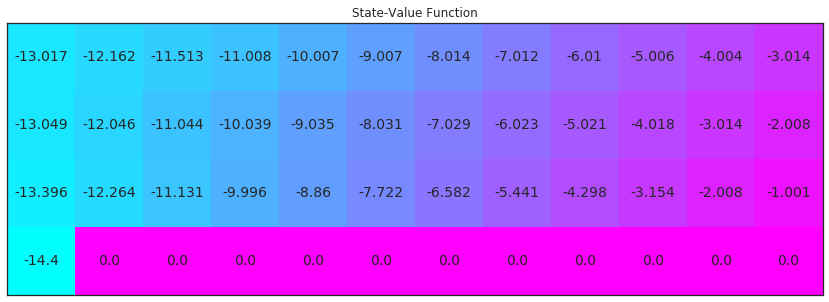

In [22]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])